# Programming Assignment 2: Convolutional Neural Networks

**Version 1.5**
- Fixed the bug in the compute_loss function in part A

**Version Release Date**: 2022-02-05

**Due Date**: Friday, Feb. 18, at 11:59pm

Based on an assignment by Lisa Zhang

For CSC413/2516 in Winter 2022 with Professors Jimmy Ba and Bo Wang

**Submission:**
You must submit two files through [MarkUs](https://markus.teach.cs.toronto.edu/2022-01/): a PDF file containing your writeup, titled *a2-writeup.pdf*, and your code file *a2-code.ipynb*. Your writeup must be typeset.

The programming assignments are individual work. See the Course Syllabus for detailed policies. 

**Introduction:**  
This assignment will focus on the applications of convolutional neural networks in various image processing tasks. First, we will train a convolutional neural network for a task known as image colourization. Given a greyscale image, we will predict the colour at each pixel. This a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple,  equally valid colourings. 

In the second half of the assignment, we switch gears and perform object detection by fine-tuning a pre-trained model. Specifically, we use the YOLOv3 ([Redmon and Farhadi, 2018](https://arxiv.org/pdf/1804.02767.pdf)) pre-trained model and fine-tune it on the COCO ([Lin et al., 2014](https://link.springer.com/content/pdf/10.1007/978-3-319-10602-1_48.pdf)) dataset.

# Colab FAQ and Using GPU

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb).

You need to use the Colab GPU for this assignment by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Download CIFAR and Colour dictionary
We will use the [CIFAR-10 data set](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. To make the problem easier, we will only use the “Horse” category from this data set. Now let’s learn to colour some horses!

The data loading script is included below. It can take up to a couple of minutes to download everything the first time.

All files are stored at `/content/csc413/a2/data/` folder.

#### Helper code
You can ignore the restart warning.

In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/csc413/a2/
%cd /content/csc413/a2

######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

/content/csc413/a2


#### Download files

This may take 1 or 2 mins for the first time.

In [ ]:
# Download cluster centers for k-means over colours
colours_fpath = get_file(
    fname="colours", origin="http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz", untar=True
)
# Download CIFAR dataset
m = load_cifar10()

File path: data/colours.tar.gz
File path: data/cifar-10-batches-py.tar.gz


# Image Colourization as Classification

We will select a subset of 24 colours and frame colourization as a pixel-wise classification problem, where we label each pixel with one of 24 colours. The 24 colours are selected using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) over colours, and selecting cluster centers. 

This was already done for you, and cluster centers are provided in http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz, which was downloaded by the helper functions above. For simplicity, we will measure distance in RGB space. This is not ideal but reduces the software dependencies for this assignment.

## Helper code

In [ ]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from load_data import load_cifar10

HORSE_CATEGORY = 7

#### Data related code

In [ ]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i : i + batch_size, :, :, :], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result


def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours, 1, 3, 1, 1])
    dists = np.linalg.norm(xs - cs, axis=2)  # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat


def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]


def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)

#### Torch helper

In [ ]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """
    batch = outputs.size(0)
    loss_out = outputs.transpose(1, 3).contiguous().view([batch * 32 * 32, num_colours])
    loss_lab = labels.transpose(1, 3).contiguous().view([batch * 32 * 32])
    return criterion(loss_out, loss_lab)


def run_validation_step(
    cnn,
    criterion,
    test_grey,
    test_rgb_cat,
    batch_size,
    colours,
    plotpath=None,
    visualize=True,
    downsize_input=False
):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey, test_rgb_cat, batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(
            criterion, outputs, labels, batch_size=args.batch_size, num_colours=num_colours
        )
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath:  # only plot if a path is provided
        plot(
            xs,
            ys,
            predicted.cpu().numpy(),
            colours,
            plotpath,
            visualize=visualize,
            compare_bilinear=downsize_input,
        )

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

#### Visualization

In [ ]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10, :, :, :], [0, 2, 3, 1])
    gtcolor = get_cat_rgb(gtlabel[:10, 0, :, :], colours)
    predcolor = get_cat_rgb(output[:10, 0, :, :], colours)

    img_stack = [np.hstack(np.tile(grey, [1, 1, 1, 3])), np.hstack(gtcolor), np.hstack(predcolor)]

    if compare_bilinear:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Upsample(scale_factor=2, mode="bilinear"),
        )
        gt_input = np.transpose(
            gtcolor,
            [
                0,
                3,
                1,
                2
            ],
        )
        color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
        color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
        img_stack = [
            np.hstack(np.transpose(input[:10, :, :, :], [0, 2, 3, 1])),
            np.hstack(gtcolor),
            np.hstack(predcolor),
            np.hstack(color_bilinear),
        ]
    img = np.vstack(img_stack)

    plt.grid(None)
    plt.imshow(img, vmin=0.0, vmax=1.0)
    if visualize:
        plt.show()
    else:
        plt.savefig(path)


def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax) * 255).astype(np.uint8))


def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]

    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + "/act" + str(id)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    images, labels = get_torch_vars(
        np.expand_dims(test_grey[id], 0), np.expand_dims(test_rgb_cat[id], 0)
    )
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0, 0, :, :], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1).save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
        img = np.tile(np.transpose(test_grey[id], [1, 2, 0]), [1, 1, 3])
    else:
        img = np.transpose(test_grey[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, "input_%d_gt.png" % id))

    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        img = np.vstack(
            [
                np.hstack(
                    [
                        add_border(filter)
                        for filter in activation[i * imgwidth : (i + 1) * imgwidth, :, :]
                    ]
                )
                for i in range(activation.shape[0] // imgwidth)
            ]
        )
        scipy.misc.imsave(path, img)

    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i + 1, id)), tensor.data.cpu().numpy()[0]
        )
    print("visualization results are saved to %s" % outdir)

#### Training

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True, encoding="bytes")[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb_cat, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(
                criterion, outputs, labels, batch_size=args.batch_size, num_colours=num_colours
            )
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(
                xs,
                ys,
                predicted.cpu().numpy(),
                colours,
                save_dir + "/train_%d.png" % epoch,
                args.visualize,
                args.downsize_input,
            )

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(
            cnn,
            criterion,
            test_grey,
            test_rgb_cat,
            args.batch_size,
            colours,
            save_dir + "/test_%d.png" % epoch,
            args.visualize,
            args.downsize_input,
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

## Part A: Pooling and Upsampling (2 pts)

### Question 1

Complete the `PoolUpsampleNet` CNN model following the architecture described in the assignment handout.

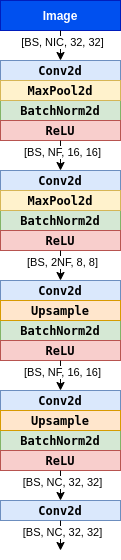

In the diagram above, we denote the number of filters as **NF**. Further layers double the number of filters, denoted as **2NF**. In the final layers, the number of filters will be equivalent to the number of colour classes, denoted as **NC**. Consequently, your constructed neural network should define the number of input/output layers with respect to the variables `num_filters` and `num_colours`, as opposed to a constant value.


The specific modules to use are listed below. If parameters are not otherwise specified, use the default PyTorch parameters.

- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) — The number of input filters should match the second dimension of the _input_ tensor (e.g. the first `nn.Conv2d` layer has **NIC** input filters). The number of output filters should match the second dimension of the _output_ tensor (e.g. the first `nn.Conv2d` layer has **NF** output filters). Set kernel size to parameter `kernel`. Set padding to the `padding` variable included in the starter code.
- [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) — Use `kernel_size=2` for all layers.
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.BatchNorm2d) — The number of features is specified after the hyphen in the diagram as a multiple of **NF** or **NC**.
- [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample) — Use `scaling_factor=2` for all layers.
- [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)


We recommend grouping each block of operations (those adjacent without whitespace in the diagram) into [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) containers. Grouping up relevant operations will allow for easier implementation of the `forward` method.

In [ ]:
class PoolUpsampleNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        padding = kernel // 2

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        self.kernel = kernel
        self.padding = padding
        self.num_filters = num_filters
        self.num_colours = num_colours
        self.num_in_channels = num_in_channels

        self.layer1 = nn.Sequential(
          nn.Conv2d(num_in_channels, num_filters, kernel, padding = padding),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.layer2 = nn.Sequential(
          nn.Conv2d(num_filters, 2*num_filters, kernel_size= kernel, padding = padding),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(2*num_filters),
          nn.ReLU()
        )
        self.layer3 = nn.Sequential(
          nn.Conv2d(2*num_filters, num_filters, kernel, padding = padding),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(num_filters, num_colours, kernel_size=kernel, padding= padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
        )
        self.layer5 = nn.Conv2d(num_colours, num_colours, kernel_size= kernel, padding = padding)
        ###################################################
    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        y = self.layer5(layer4)
        return y



### Question 2

Run main training loop of `PoolUpsampleNet`. This will train the CNN for a few epochs using the cross-entropy objective. It will generate some images showing the trained result at the end. Do these results look good to you? Why or why not?

Answer: The result after running PoolUpsampleNet was terrible. The final validation accuracy reaches 41% after 25 epochs, which is very low. We can see the background has not been correctly colourized from the graph.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.4493, Time (s): 2
Epoch [1/25], Val Loss: 2.1638, Val Acc: 26.5%, Time(s): 2.55
Epoch [2/25], Loss: 2.0010, Time (s): 4
Epoch [2/25], Val Loss: 1.9076, Val Acc: 33.3%, Time(s): 4.99
Epoch [3/25], Loss: 1.8753, Time (s): 7
Epoch [3/25], Val Loss: 1.8165, Val Acc: 35.7%, Time(s): 7.50
Epoch [4/25], Loss: 1.8121, Time (s): 9
Epoch [4/25], Val Loss: 1.7682, Val Acc: 36.9%, Time(s): 10.05
Epoch [5/25], Loss: 1.7732, Time (s): 12
Epoch [5/25], Val Loss: 1.7367, Val Acc: 37.7%, Time(s): 12.67
Epoch [6/25], Loss: 1.7461, Time (s): 14
Epoch [6/25], Val Loss: 1.7142, Val Acc: 38.2%, Time(s): 15.29
Epoch [7/25], Loss: 1.7247, Time (s): 17
Epoch [7/25], Val Loss: 1.6912, Val Acc: 38.7%, Time(s): 17.94
Epoch [8/25], Loss: 1.7068, Time (s): 20
Epoch [8/25], Val Loss: 1.6759, Val Acc: 39.1%, Time(s): 20.66
Epoch [9/25], Loss: 1.6918, Time (s): 22
Epoch [9/25], Val Loss: 1.6642,

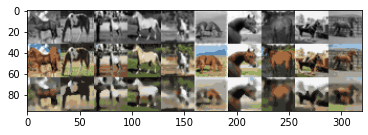

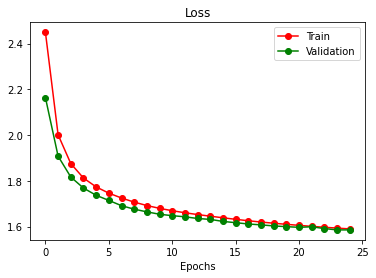

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "PoolUpsampleNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

### Question 3

let $k$ denote kernel size

For 32x32:

number of weights = $k^2*NIC*NF + 2*k^2*2*{NF}^2 + k^2*NF*NC + k^2*{NC}^2$

number of outputs = $({32}^2*NF + 2*{16}^2*NF) + ({16}^2*2*NF + 2*{8}^2*2*NF) + ({8}^2*NF + 2*{16}^2*NF) + ({16}^2*NC + 2*{32}^2*NC) + {32}^2*NC$

number of connections = $({32}^2*k^2*NIC*NF + {32}^2*NF) + ({16}^2*k^2*2*{NF}^2 + {16}^2*2*NF) + ({8}^2*k^2*2*{NF}^2 + {16}^2*NF) + ({16}^2*k^2*NF*NC + {32}^2*NC) + {32}^2*k^2*NC^2$ 

For the 64x64:

number of weights = $k^2*NIC*NF + 2*k^2*2*{NF}^2 + k^2*NF*NC + K^2*{NC}^2$

number of outputs = $({64}^2*NF + 2*{32}^2*NF) + ({32}^2*2*NF + 2*{16}^2*2*NF) + ({16}^2*NF + 2*{32}^2*NF) + ({32}^2*NC + 2*{64}^2*NC) + {64}^2*NC$

number of connections = $({64}^2*k^2*NIC*NF + {64}^2*NF) + ({32}^2*k^2*2*{NF}^2 + {32}^2*2*NF) + ({16}^2*k^2*2*{NF}^2 + {32}^2*NF) + ({32}^2*k^2*NF*NC + {64}^2*NC) + {64}^2*k^2*NC^2$

## Part B: Strided and Transposed Dilated Convolutions (3 pts)

### Question 1

Complete the `ConvTransposeNet` CNN model following the architecture described in the assignment handout.

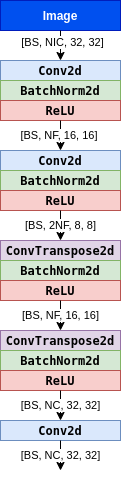

An excellent visualization of convolutions and transposed convolutions with strides can be found here: <https://github.com/vdumoulin/conv_arithmetic>.

The specific modules to use are listed below. If parameters are not otherwise specified, use the default PyTorch parameters.

- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) — The number of input and output filters, and the kernel size, should be set in the same way as Part A. For the first two `nn.Conv2d` layers, set `stride` to 2 and set `padding` to 1.
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.BatchNorm2d) — The number of features should be specified in the same way as for Part A.
- [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) — The number of input filters should match the second dimension of the _input_ tensor. The number of output filters should match the second dimension of the _output_ tensor. Set `kernel_size` to parameter `kernel`. Set `stride` to 2, set `dilation` to 1, and set both `padding` and `output_padding` to 1.
- [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)

In [ ]:
class ConvTransposeNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        self.kernel = kernel
        self.num_filters = num_filters
        self.num_colours = num_colours
        self.num_in_channels = num_in_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, stride=2, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(num_filters, 2*num_filters, kernel_size=kernel, stride=2, padding=1),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2*num_filters, num_filters, kernel_size=kernel, stride= 2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_colours, kernel_size=kernel, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
        )

        self.layer5 = nn.Conv2d(num_colours, num_colours, kernel_size= kernel, padding=padding)

        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        y = self.layer5(layer4)
        return y
        ###################################################

### Question 2

Train the model for at least 25 epochs using a batch size of 100 and a kernel size of 3. Plot the training curve, and include this plot in your write-up. How do the results compare to the previous model?

Answer: The result from part b seems better than part a, with a higher final validation accuracy of 55% and a lower validation loss of 1.14. It is because we replace the MaxPool and Upsample layers with convolution layers since Maxpool/Upsample is used to decrease dimension, which involves some information loss. And also, Maxpool/Upsample do not contain learnable parameters, but convolution transposed layers do.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.0763, Time (s): 2
Epoch [1/25], Val Loss: 1.7097, Val Acc: 37.3%, Time(s): 2.51
Epoch [2/25], Loss: 1.6684, Time (s): 4
Epoch [2/25], Val Loss: 1.5352, Val Acc: 43.0%, Time(s): 4.90
Epoch [3/25], Loss: 1.5618, Time (s): 7
Epoch [3/25], Val Loss: 1.4427, Val Acc: 46.1%, Time(s): 7.35
Epoch [4/25], Loss: 1.4950, Time (s): 9
Epoch [4/25], Val Loss: 1.3795, Val Acc: 48.2%, Time(s): 9.84
Epoch [5/25], Loss: 1.4466, Time (s): 11
Epoch [5/25], Val Loss: 1.3330, Val Acc: 49.8%, Time(s): 12.39
Epoch [6/25], Loss: 1.4091, Time (s): 14
Epoch [6/25], Val Loss: 1.2968, Val Acc: 50.9%, Time(s): 14.99
Epoch [7/25], Loss: 1.3791, Time (s): 17
Epoch [7/25], Val Loss: 1.2670, Val Acc: 51.9%, Time(s): 17.64
Epoch [8/25], Loss: 1.3547, Time (s): 19
Epoch [8/25], Val Loss: 1.2409, Val Acc: 52.8%, Time(s): 20.33
Epoch [9/25], Loss: 1.3348, Time (s): 22
Epoch [9/25], Val Loss: 1.2207, 

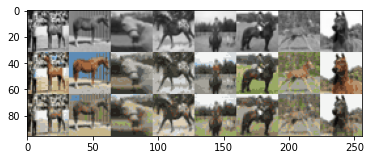

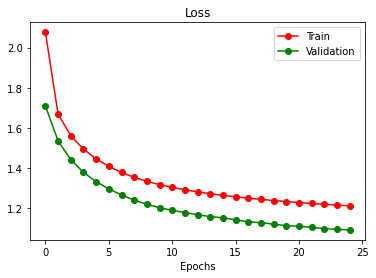

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "ConvTransposeNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 32,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

### Questions 3 – 5

See assignment handout.

## Part C. Skip Connections (1 pts)


A skip connection in a neural network is a connection which skips one or more layer and connects
to a later layer. We will introduce skip connections to our previous model.

### Question 1

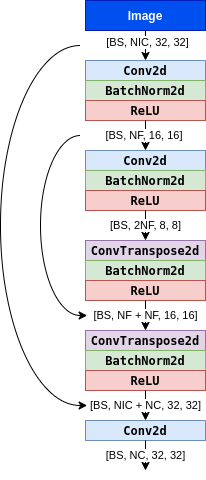

In this question, we will be adding a skip connection from the first layer to the last, second layer to the second last, etc. That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [Ronneberger et al.[2015]](https://arxiv.org/abs/1505.04597), and is called a ”UNet”. 

Just like the `ConvTransposeNet` class that you have completed in the previous part, complete the `__init__` and `forward` methods methods of the `UNet` class below.

Hint: You will need to use the function `torch.cat`.

In [ ]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        self.kernel = kernel
        self.num_filters = num_filters
        self.num_colours = num_colours
        self.num_in_channels = num_in_channels

        self.layer1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, stride=2, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_filters, 2*num_filters, kernel_size=kernel, stride=2, padding=1),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2*num_filters, num_filters, kernel_size=kernel, stride= 2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(num_filters + num_filters, num_colours, kernel_size=kernel, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
        )
        self.layer5 = nn.Conv2d(num_colours+num_in_channels, num_colours, kernel_size= kernel, padding=padding) 
        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer13 = torch.cat((layer1, layer3), dim = 1)
        layer4 = self.layer4(layer13)
        layerx4 = torch.cat((x, layer4), dim = 1)
        y = self.layer5(layerx4)
        return y
        ###################################################

### Question 2

Train the model for at least 25 epochs using a batch size of 100 and a kernel size of 3. Plot the training curve, and include this plot in your write-up.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.4205, Time (s): 2
Epoch [1/25], Val Loss: 2.0574, Val Acc: 31.6%, Time(s): 2.57
Epoch [2/25], Loss: 1.8162, Time (s): 4
Epoch [2/25], Val Loss: 1.6982, Val Acc: 39.3%, Time(s): 5.05
Epoch [3/25], Loss: 1.6364, Time (s): 7
Epoch [3/25], Val Loss: 1.5703, Val Acc: 42.7%, Time(s): 7.58
Epoch [4/25], Loss: 1.5411, Time (s): 9
Epoch [4/25], Val Loss: 1.4853, Val Acc: 45.2%, Time(s): 10.14
Epoch [5/25], Loss: 1.4733, Time (s): 12
Epoch [5/25], Val Loss: 1.4222, Val Acc: 47.0%, Time(s): 12.76
Epoch [6/25], Loss: 1.4207, Time (s): 15
Epoch [6/25], Val Loss: 1.3712, Val Acc: 48.7%, Time(s): 15.44
Epoch [7/25], Loss: 1.3780, Time (s): 17
Epoch [7/25], Val Loss: 1.3358, Val Acc: 49.6%, Time(s): 18.14
Epoch [8/25], Loss: 1.3424, Time (s): 20
Epoch [8/25], Val Loss: 1.2978, Val Acc: 50.9%, Time(s): 20.90
Epoch [9/25], Loss: 1.3123, Time (s): 23
Epoch [9/25], Val Loss: 1.2706,

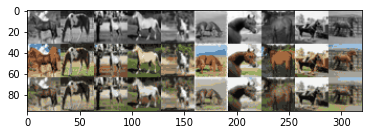

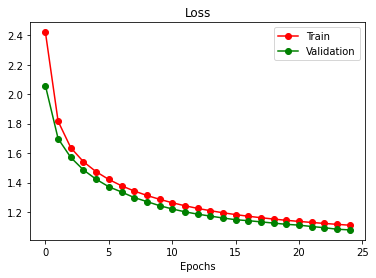

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

### Question 3

See assignment handout.

# Object Detection as Regression and Classification - the YOLO approach

In the previous two parts, we worked on training models for image colourization. Now we will switch gears and perform object detection by fine-tuning a pre-trained model. 

For the following, you are not expected to read the referenced papers, though the writing is very entertaining (by academic paper standards) and it may help provide additional context.

We use the YOLO (You Only Look Once) approach, as laid out in the [the original paper by Redmon et al](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf). YOLO uses a single neural network to predict bounding boxes (4 coordinates describing the corners of the box bounding a particular object) and class probabilities (what object is in the bounding box) based on a single pass over an image. It first divides the image into a grid, and for each grid cell predicts bounding boxes, confidence for those boxes, and conditional class probabilities. 

For the YOLOv3 model, which we use here, we draw from [their YOLOv3 paper](https://arxiv.org/pdf/1804.02767.pdf) which also builds on the previous [YOLO9000 paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Redmon_YOLO9000_Better_Faster_CVPR_2017_paper.pdf). 

We use the pretrained YOLOv3 model weights and fine-tune it on the COCO ([Lin et al., 2014](https://link.springer.com/content/pdf/10.1007/978-3-319-10602-1_48.pdf)) dataset.

##Setup

In [ ]:
!git clone https://github.com/Silent-Zebra/2022

Cloning into '2022'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 396 (delta 131), reused 323 (delta 58), pack-reused 0
Receiving objects: 100% (396/396), 53.04 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (131/131), done.


Rerun the cd command below if you restart the runtime (but everything should work fine without restarting the runtime anyway)

In [ ]:
%cd 2022/assets/assignments/pa2-q4-files

[Errno 2] No such file or directory: '2022/assets/assignments/pa2-q4-files'
/content/2022/assets/assignments/pa2-q4-files


In [ ]:
def notebook_init():
    # For  notebooks
    print('Checking setup...')
    from IPython import display  # to display images and clear console output

    from utils.general import emojis
    from utils.torch_utils import select_device  # imports

    display.clear_output()
    select_device(newline=False)
    print(emojis('Setup complete ✅'))
    return display

display = notebook_init() 

YOLOv3 🚀 46dad08 torch 1.10.0+cu111 CPU


Setup complete ✅


In my experience you don't have to restart the runtime after the below installation

In [ ]:
!pip install -r requirements.txt

## Part D.1: Freezing Parameters

A common practice in computer vision tasks is to take a pre-trained model trained on a large datset and finetune only parts of the model for a specific usecase. This can be helpful, for example, for preventing overfitting if the dataset we fine-tune on is small. 

In this notebook, we are finetuning on the COCO dataset, and freezing model parameters is not strictly necessary here. However, it still allows for faster training and is meant to be instructive.

Fill in the section in `train.py` (2022/assets/assignments/pa2-q4-files/train.py) for freezing model parameters (line 129). The key idea here is to set `requires_grad` to be `False` for all frozen layers `v` and `True` for all other layers `v`. Hint: it might be helpful to check a condition such as: `any(x in k for x in freeze)`.

## Part D.2: Classification Loss
The YOLO model's loss function consists of several components, including a regression loss for the bounding box as well as a classification loss for the object in the bounding box. We will consider only the classification loss here.

For the classification loss, we will work in `utils/loss.py`.

First define in line 97 the `BCEcls` by calling `nn.BCEWithLogitsLoss` (see PyTorch documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) for reference) using `h['cls_pw']` as the positive weight for the classification, and passing in `device` as well.
Then, in line 150, add to `lcls` the loss using `self.BCEcls` called on the respective parts of the prediction related to the classification component `(ps[:, 5:])` and the target `t`.

## Training
Train the YOLOv3 model on COCO128 for 5 epochs, freezing 10 layers, by running the below cell.

You can set up an account for wandb (click on the output area at the flashing cursor where it asks you to enter your choice, and type whatever input number you like, followed by hitting enter), which provides lots of cool visualizations (during training you will see live updates at https://wandb.ai/home). For the purpose of this assignment, you can enter 3 (skipping wandb).

NOTE: This cell below should take around 6 minutes. If it is taking much longer, please double check your work on Part D.1 (freezing the model parameters)



In [ ]:
!python train.py --img 640 --batch 16 --epochs 5 --data coco128.yaml --weights yolov3.pt --cache --freeze 10

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 3
wandb: You chose 'Don't visualize my results'
train: weights=yolov3.pt, cfg=, data=coco128.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=10, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov3
YOLOv3 🚀 46dad08 torch 1.10.0+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup

## Visualization

Set up the visualization by running the below cell. Note that if you ran the training loop multiple times, you would have additional folder exp2, exp3, etc.


In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source data/images


detect: weights=['runs/train/exp/weights/best.pt'], source=data/images, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 46dad08 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Traceback (most recent call last):
  File "detect.py", line 244, in <module>
    main(opt)
  File "detect.py", line 239, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 79, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn)
  File "/content/csc413/a2/2022/assets/assignments/pa2-q4-files/models/common.py", line 305, in __init__
    model =

Display Results

In [ ]:
display.Image(filename='runs/detect/exp/Cats_and_dog.jpg', width=600)

AttributeError: ignored

In [ ]:
display.Image(filename='runs/detect/exp/bus.jpg', width=600)
